In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
folder_path = "AudioWAV"

# Lọc file HAP và NEU
files = [file for file in os.listdir(folder_path) if "HAP" in file or "NEU" in file]

In [3]:
def load_wav(file_path, max_length=16000):  # 1 giây ở 16kHz
    y, sr = librosa.load(file_path, sr=16000)  # Chuyển về 16kHz
    y = librosa.util.fix_length(y, size=max_length)  # Thêm từ khóa `size=`
  # Cắt hoặc padding về độ dài cố định
    return y


DATA AUGMENTATION

Làm nhiễu âm thanh

In [4]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

Dịch chuyển tín hiệu âm thanh

In [5]:
def shift(data):
    s_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, s_range)

In [6]:
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

Thay đổi cao độ

In [7]:
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

LOAD DATA

In [8]:
X, y = [], []
for file in files:
    file_path = os.path.join(folder_path, file)
    waveform = load_wav(file_path)
    # Data augmentation

    X.append(waveform)
    y.append(0 if "HAP" in file else 1)  # 0: Happy, 1: Neutral

X = np.array(X).reshape(-1, 16000, 1)  # Reshape thành (số mẫu, độ dài, 1)
y = np.array(y)

In [9]:
print(X.shape, y.shape)

(2358, 16000, 1) (2358,)


TEST DATA

In [10]:
import IPython.display as ipd

index = 0  # Chọn index của file muốn nghe (0, 1, 2, ...)
ipd.Audio(X[index].reshape(-1), rate=16000)  # Phát âm thanh với tần số 16kHz



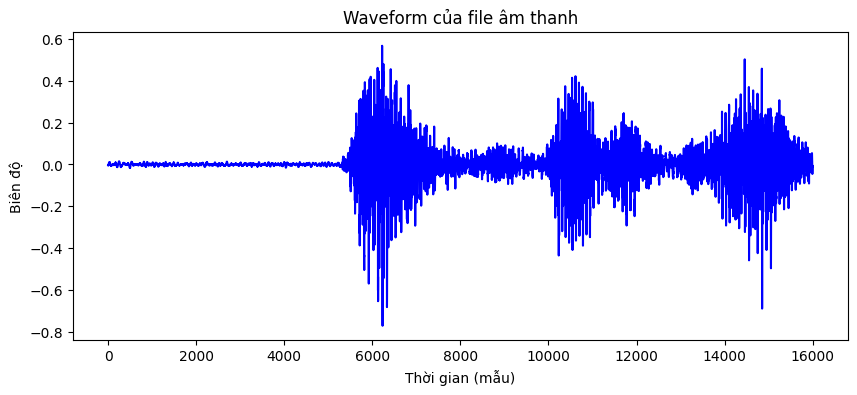

In [43]:
import matplotlib.pyplot as plt

# Lấy sóng âm từ file đã chọn
waveform = X[index].reshape(-1)

# Vẽ dạng sóng
plt.figure(figsize=(10, 4))
plt.plot(waveform, color="blue")
plt.title("Waveform của file âm thanh")
plt.xlabel("Thời gian (mẫu)")
plt.ylabel("Biên độ")
plt.show()

Âm thanh khi bị nhiễu

In [44]:
noise_waveform = noise(waveform)
ipd.Audio(noise_waveform.reshape(-1), rate=16000)  # Phát âm thanh với tần số 16kHz

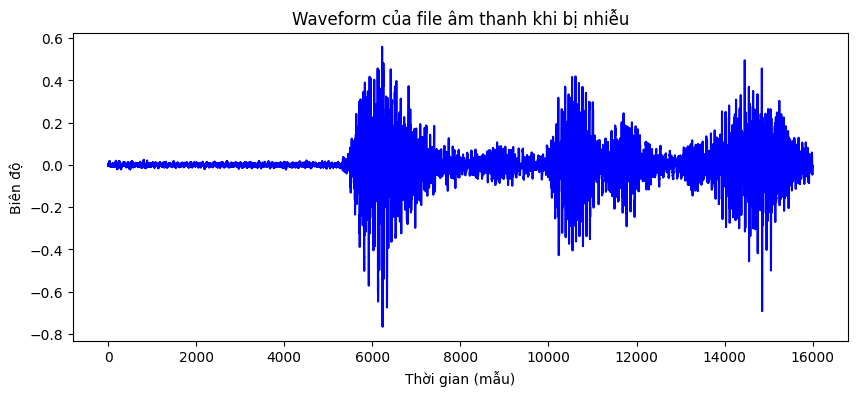

In [45]:


# Vẽ dạng sóng
plt.figure(figsize=(10, 4))
plt.plot(noise_waveform, color="blue")
plt.title("Waveform của file âm thanh khi bị nhiễu")
plt.xlabel("Thời gian (mẫu)")
plt.ylabel("Biên độ")
plt.show()

In [46]:
shift_waveform = shift(waveform)
ipd.Audio(shift_waveform.reshape(-1), rate=16000)  # Phát âm thanh với tần số 16kHz

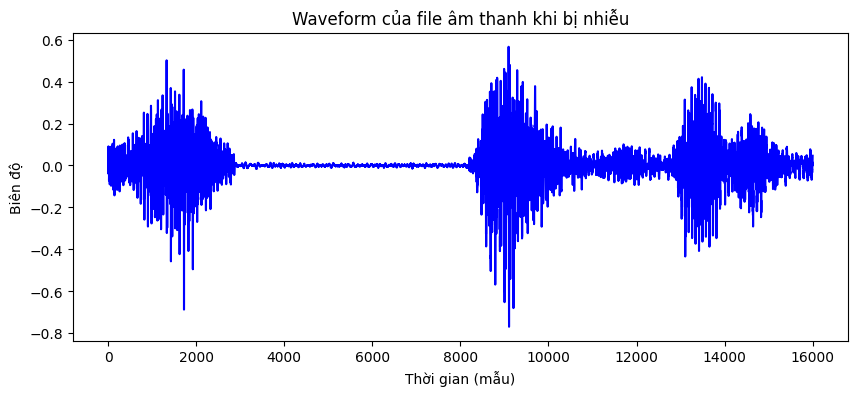

In [47]:
# Vẽ dạng sóng
plt.figure(figsize=(10, 4))
plt.plot(shift_waveform, color="blue")
plt.title("Waveform của file âm thanh khi bị nhiễu")
plt.xlabel("Thời gian (mẫu)")
plt.ylabel("Biên độ")
plt.show()

In [48]:
pitch_waveform = pitch(waveform, 16000)
ipd.Audio(pitch_waveform.reshape(-1), rate=16000)  # Phát âm thanh với tần số 16kHz

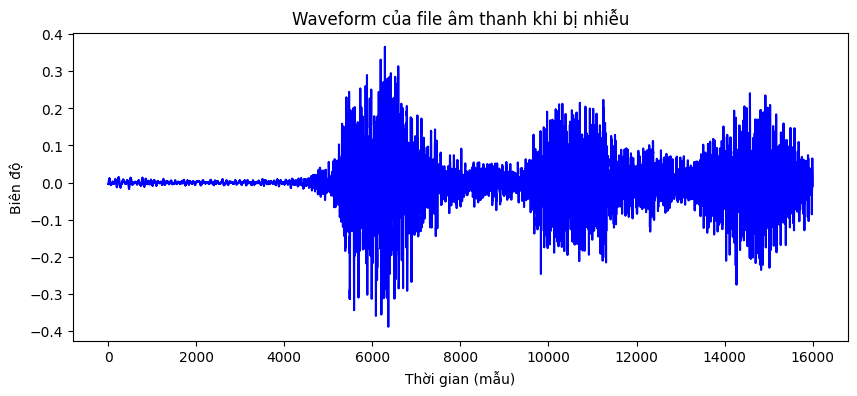

In [49]:
# Vẽ dạng sóng
plt.figure(figsize=(10, 4))
plt.plot(pitch_waveform, color="blue")
plt.title("Waveform của file âm thanh khi bị nhiễu")
plt.xlabel("Thời gian (mẫu)")
plt.ylabel("Biên độ")
plt.show()

In [10]:

# Tạo tập dữ liệu mới
X_new, y_new = [], []

for i in range(len(X)):
    waveform = X[i].reshape(-1)  # Lấy tín hiệu gốc
    label = y[i]                 # Nhãn của file

    # Thêm dữ liệu gốc
    X_new.append(waveform)
    y_new.append(label)

    # Tạo dữ liệu bị nhiễu
    noisy_waveform = noise(waveform)
    shift_waveform = shift(waveform)
    #stretch_waveform = stretch(waveform)
    pitch_waveform = pitch(waveform, 16000)
    # Thêm dữ liệu nhiễu
    X_new.append(noisy_waveform)
    y_new.append(label)
    X_new.append(shift_waveform)
    y_new.append(label)
    X_new.append(pitch_waveform)
    y_new.append(label)

# Chuyển về numpy array
X_new = np.array(X_new).reshape(-1, 16000, 1)
y_new = np.array(y_new)




Chưa chuẩn hóa dữ liệu (lấy lúc bắt đầu nói, chuẩn hóa về cùng 1 thời gian)

In [11]:
def extract_mfcc_from_array(audio_array, sampling_rate):
    """
    Trích xuất đặc trưng MFCC từ mảng numpy thay vì file âm thanh.
    
    Parameters:
        - audio_array: numpy array chứa dữ liệu âm thanh
        - sampling_rate: tần số lấy mẫu của dữ liệu âm thanh

    Returns:
        - mfcc: Mảng numpy (40,) chứa đặc trưng MFCC trung bình theo thời gian.
    """
    mfcc = np.mean(librosa.feature.mfcc(y=audio_array, sr=sampling_rate, n_mfcc=40).T, axis=0)
    return mfcc

MFCC (Mel-frequency Cepstral Coefficients)

- Giúp phân tích cách con người nghe âm thanh.

- Chia âm thanh thành nhiều tần số khác nhau và lấy 40 giá trị đặc trưng từ đó.

- Dùng để nhận diện giọng nói và phân biệt âm thanh.

Zero-Crossing Rate (ZCR)

- Đếm số lần tín hiệu thay đổi từ dương sang âm (hoặc ngược lại).

- Giúp nhận biết âm thanh có nhiều dao động nhanh (âm sắc cao, như tiếng xì xào) hay chậm (âm trầm, như giọng nói).

Chromagram (Chroma STFT)

- Xác định tần số nào mạnh nhất trong một khoảng thời gian.

- Đặc biệt hữu ích để nhận diện hợp âm trong nhạc.

RMS (Root Mean Square Energy)

- Đo độ lớn trung bình của tín hiệu (độ mạnh hay yếu của âm thanh).

- Giúp phân biệt âm thanh to (như tiếng hét) và nhỏ (như tiếng thì thầm).

Mel Spectrogram

- Hiển thị cách năng lượng âm thanh thay đổi theo thời gian ở các tần số khác nhau.

- Dựa trên cách con người cảm nhận âm thanh, giúp máy hiểu âm thanh giống như tai người.

In [11]:
def extract_feature(data, sampling_rate):
    result = np.array([])
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc))

    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sampling_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # Root Mean Square Value --> ok
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

        # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sampling_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

In [ ]:
# X_new_mfcc = np.array([extract_mfcc_from_array(x.reshape(-1), 16000) for x in X_new])


In [12]:
X_new_mfcc = np.array([extract_feature(x.reshape(-1), 16000) for x in X_new])

In [13]:
import pandas as pd

Features = pd.DataFrame(X_new_mfcc)
Features['labels'] = y_new
Features.to_csv('Features.csv', index=False)



In [14]:
X_new=np.array(X_new_mfcc)
print(X_new.shape)
print(y_new)

(9432, 142)
[0 0 0 ... 1 1 1]


In [28]:
#chia dữ liệu thành tập huấn luyện và tập kiểm thử và tập validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=42)




In [29]:
from sklearn.preprocessing import StandardScaler
import joblib
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Save scaler
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')  # Assuming 5 classes for classification
])

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 142, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 71, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 71, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 36, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 36, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 18, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 571,522 (2.18 MB)

 Trainable params: 571,522 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
early_stopping = keras.callbacks.EarlyStopping(patience=10,monitor="val_loss", restore_best_weights=True)

In [33]:
# Train mô hình
history=model.fit(X_train, y_train, epochs=50, batch_size=4, validation_split=0.2,callbacks=[early_stopping])

Epoch 1/50
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.6336 - loss: 0.6208 - val_accuracy: 0.6858 - val_loss: 0.5842
Epoch 2/50
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.6742 - loss: 0.5887 - val_accuracy: 0.7161 - val_loss: 0.5387
Epoch 3/50
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.6910 - loss: 0.5828 - val_accuracy: 0.7063 - val_loss: 0.5714
Epoch 4/50
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.6831 - loss: 0.5750 - val_accuracy: 0.7131 - val_loss: 0.5359
Epoch 5/50
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.6944 - loss: 0.5578 - val_accuracy: 0.7169 - val_loss: 0.5375
Epoch 6/50
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.7113 - loss: 0.5446 - val_accuracy: 0.6942 - val_loss: 0.5689
Epoch 7/50
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.7066 - loss: 0.5439 - val_accuracy: 0.7207 - val_loss: 0.5204
Epoch 8/50
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.7237 -

In [34]:


# Tính các chỉ số khác
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

# Dự đoán trên tập kiểm thử
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred.argmax(axis=1)))
y_pred = y_pred.argmax(axis=1)  # Chọn lớp có xác suất cao nhất

# In classification report (Precision, Recall, F1-Score)
print(classification_report(y_test, y_pred))

# In confusion matrix
print(confusion_matrix(y_test, y_pred))



89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
0.7770318021201413
              precision    recall  f1-score   support

           0       0.85      0.72      0.78      1535
           1       0.72      0.85      0.78      1295

    accuracy                           0.78      2830
   macro avg       0.78      0.78      0.78      2830
weighted avg       0.79      0.78      0.78      2830

[[1102  433]
 [ 198 1097]]


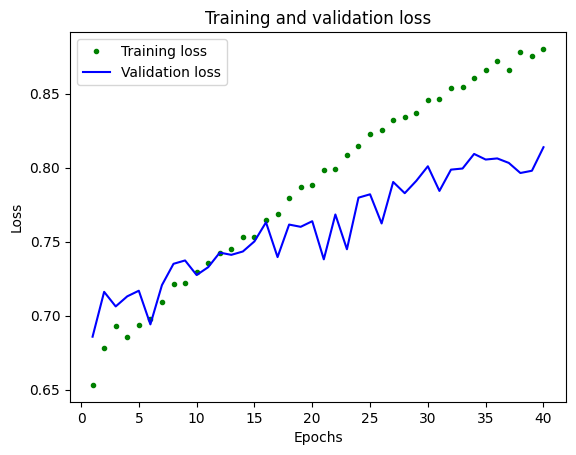

[6.4, 4.8]


In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

In [27]:
model.save("emotion_cnn1d_model.h5")